In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

In [2]:
def pos1(pos0,vel0,a0,dt):
    return pos0+vel0*dt+0.5*a0*(dt**2)
def vel1(vel0,a1,a0,dt):
    return vel0+0.5*(a1+a0)*(dt)

In [3]:
def Nearest_Instance(pos_i,pos_j,L_a):
    dx=pos_i-pos_j
    if dx>0.5*L_a:
        dx=dx-L_a
    elif dx<-0.5*L_a:
        dx=dx+L_a
    return dx

In [4]:
def Distances_to_Nearests(positions,L=6):
    #calccount is to ensure we are only running the function half the times
    calccount=0
    #By doing as a function, reduces the number of variables in global scope
    nx1=np.zeros((len(positions),len(positions)))
    #Zeros is more predicatable and typically more efficient than empty
    #print(nx1)
    for i in range(0,len(nx1)):
        for j in range(0,len(nx1[i])):
            if i==j:
                nx1[i][j]=np.nan
                #Would prefer do to string but dtype of np.zeroes is float
            else:
                if np.abs(nx1[i][j])<1e-9:
                    #Cant really equate with floats so this checks if the number has not been changed and therefore written
                    dist_x=Nearest_Instance(positions[i],positions[j],L)
                    calccount+=1
                    nx1[i][j]=dist_x
                    nx1[j][i]=-dist_x
                else:
                    if nx1[i][j]!=-nx1[j][i]:
                        print(i,j)
                        print(nx1[i][j],nx1[j,i])
                        print("Something has gone wrong")
    #print(calccount)
    nx1[-1][-1]=np.nan
    return nx1

In [6]:
def Force_calc(dx,dy):
    #get distance between them
    r=np.sqrt((dx**2)+(dy**2))
    #get total force
    F_tot=48*(((r**(-13))-0.5*(r**(-7))))
    #split between x and y components
    F_x=F_tot*(dx/r)
    F_y=F_tot*(dy/r)
    return F_x,F_y
def Pot_calc(dx,dy):
    r=np.sqrt((dx)**2+(dy)**2)
    u=4*(r**(-12)-r**(-6))
    return u

In [8]:
def Net_Force_U_Calc(dxs,dys):
    calccount=0
    #Create zeroes arrays of length N^2, The forces on the particle itself due to itself should remain 0 
    x_forces=np.zeros(np.shape(dxs))
    y_forces=np.zeros(np.shape(dys))
    U_array=np.zeros(np.shape(dxs))
    #Go through each of the particles
    for i in range(0,len(dxs)):
        #Now determine the force on this particle due to the N-1 particles
        for j in range (0,len(dxs[i])):
            #Uses these if statements to prevent calculating the force from the object itself as well as preventing recalculation
            if (dxs[i][j]!=np.nan) & (dys[i][j]!=np.nan)&(np.abs(x_forces[i][j])<1e-9)&(np.abs(y_forces[i][j])<1e-9):
                #print(i,j)
                F_x,F_y=Force_calc(dxs[i][j],dys[i][j])
                Pot=Pot_calc(dxs[i][j],dys[i][j])
                calccount+=1
                #It looks like its counting a few too many times? Should be 120 but is doing 136
                #This takes advantage of NIII
                x_forces[i][j]=F_x
                x_forces[j][i]=-F_x
                y_forces[i][j]=F_y
                y_forces[j][i]=-F_y
                U_array[i][j]=Pot
                U_array[j][i]=Pot

    #print(calccount)
    #Find net forces by calculating the net x and y forces that each particle experiences
    Net_x_Forces=[np.nansum(el) for el in x_forces]
    Net_y_Forces=[np.nansum(el) for el in y_forces]
    Net_Potentials=[np.nansum(el) for el in U_array]
    return Net_x_Forces,Net_y_Forces,Net_Potentials

In [9]:
def Mover(Posx0,Posy0,v_x0,v_y0,tmax,dt=0.01,L=6):
    Tot_Pots=[]
    Tot_kin=[]
    Left_nums=[]
    x_array=[]
    y_array=[]
    vx_array=[]
    vy_array=[]
    ax_array=[]
    ay_array=[]
    #The : in the following statements are to make copies to prevent changing original
    x0=Posx0[:]
    y0=Posy0[:]
    vx0=v_x0[:]
    vy0=v_y0[:]
    ax0=np.zeros(len(Posx0))
    ay0=np.zeros(len(Posx0))
    ax1=np.zeros(len(Posx0))
    ay1=np.zeros(len(Posx0))
    t=0
    while t<tmax:
        #Get nearest distances
        dxs=Distances_to_Nearests(x0,L)
        dys=Distances_to_Nearests(y0,L)
        #Get x,y net forces and potential
        xf,yf,FPots=Net_Force_U_Calc(dxs,dys)
        Tot_Pots.append(np.nansum(FPots))
        #Get kinetic energy
        Tot_kin.append(np.sum([0.5*v**2 for v in vx0]+[0.5*v**2 for v in vy0]))
        #Get number of molecules on left side
        Left_num=len([x for x in x0 if 0<=x<=L/2])
        Left_nums.append(Left_num)
        #prep for movement by noting current values 
        x_array.append(x0)
        y_array.append(y0)
        vx_array.append(vx0)
        vy_array.append(vy0)
        ax_array.append(ax1)
        ay_array.append(ay1)
        #movement
        ax1=xf[:]
        ay1=yf[:]
        #This copy stuff was found to be needed due to way python decides to work in terms of value by reference
        #The issue was that it was computing the new values, replacing the values and then duplicating these new values
        copy_x0=x0[:]
        copy_y0=y0[:]
        copy_vx0=vx0[:]
        copy_vy0=vy0[:]
        for i in range(0,len(x0)):
            copy_x0[i]=pos1(x0[i],vx0[i],ax0[i],dt)
            copy_y0[i]=pos1(y0[i],vy0[i],ay0[i],dt)
            copy_vx0[i]=vel1(vx0[i],ax1[i],ax0[i],dt)
            copy_vy0[i]=vel1(vy0[i],ay1[i],ay0[i],dt)
            if copy_x0[i]>L:
                #print('test1',copy_x0[i])
                copy_x0[i]=copy_x0[i]%L
                #print(copy_x0[i])
            if copy_x0[i]<0:
                #print('test2',copy_x0[i])
                copy_x0[i]=L-np.abs(copy_x0[i])%L
                #print(copy_x0[i])
            if copy_y0[i]>L:
                #print('test3',copy_y0[i])
                copy_y0[i]=copy_y0[i]%L
                #print(copy_y0[i])
            if copy_y0[i]<0:
                #print('test4',copy_y0[i])
                copy_y0[i]=L-np.abs(copy_y0[i])%L
                #print(copy_y0[i])


        x0=copy_x0[:]
        y0=copy_y0[:]
        vx0=copy_vx0[:]
        vy0=copy_vy0[:]
        ax0=ax1[:]
        ay0=ay1[:]


        t+=dt
    #print(np.shape(x_array))
    return Tot_Pots,Tot_kin,Left_nums,x_array,y_array,vx_array,vy_array,ax_array,ay_array

In [10]:
x_0=[1.25,2.5,3.75,5]
y_0=[1.25,2.5,3.75,5]
vx_0=[0.2,0.1,-0.2,-0.1]
vy_0=[0.2,0.1,-0.2,-0.1]

In [148]:
u_1,k_1,l_1,x_1,y_1,vx_1,vy_1,ax_1,ay_1=Mover(x_0,y_0,vx_0,vy_0,200,dt=0.00005)

KeyboardInterrupt: 

[-0.17636588920944493, -0.18733440870362153, 0.9570305989825828, -0.5933303010694316]


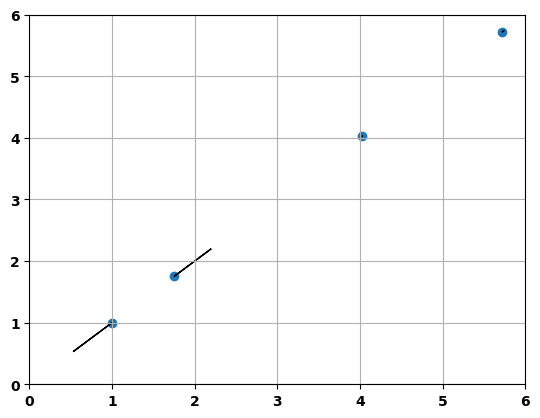

In [145]:
test_index=-1
plt.scatter(x_1[test_index],y_1[test_index])
#plt.scatter(x_1[test_index],y_1[test_index])
#plt.xlim(0,6)
#plt.ylim(0,6)
for i in range(0,len(x_1[test_index])):
    plt.arrow(x_1[test_index][i],y_1[test_index][i],0.1*ax_1[test_index][i],0.1*ay_1[test_index][i])
#for i in range(0,len(x_1[test_index])):
    #plt.arrow(x_1[test_index][i],y_1[test_index][i],0.1*ax_1[test_index][i],0.1*ay_1[test_index][i],color='r')
plt.xlim(0,6)
plt.ylim(0,6)
#plt.scatter(x_1[19],y_1[19])
#plt.xlim(0,6)
print(vx_1[test_index])
plt.grid(True)

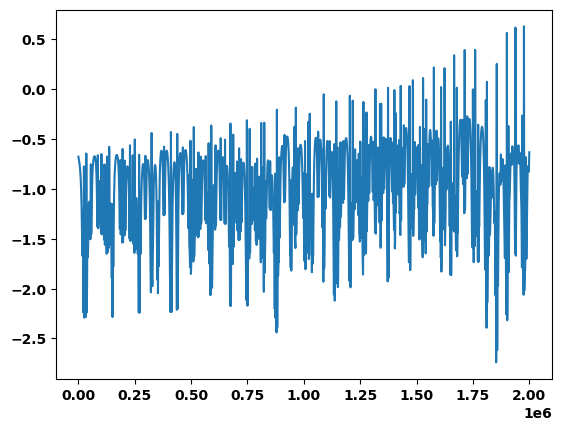

In [146]:
plt.plot([u_1[i]+k_1[i] for i in range(0,len(u_1))])
#plt.xlim(200,250)
#plt.ylim(-1e+1,1e+3)

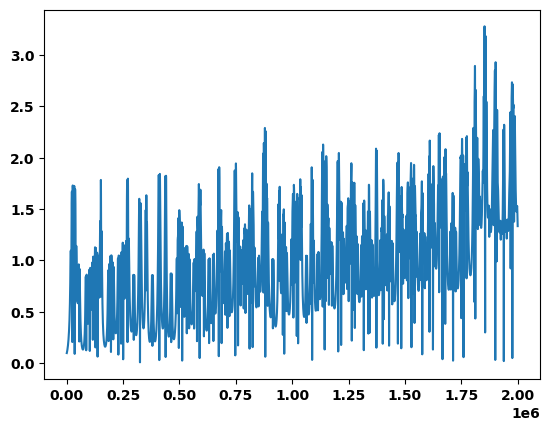

In [147]:
plt.plot(k_1)

In [150]:
def Mover(Posx0,Posy0,v_x0,v_y0,tmax,dt=0.01,L=6):
    Tot_Pots=[]
    Tot_kin=[]
    Left_nums=[]
    x_array=[]
    y_array=[]
    vx_array=[]
    vy_array=[]
    ax_array=[]
    ay_array=[]
    #The : in the following statements are to make copies to prevent changing original
    x0=Posx0[:]
    y0=Posy0[:]
    vx0=v_x0[:]
    vy0=v_y0[:]
    ax0=np.zeros(len(Posx0))
    ay0=np.zeros(len(Posx0))
    ax1=np.zeros(len(Posx0))
    ay1=np.zeros(len(Posx0))
    t=0
    while t<tmax:
        #Get nearest distances
        dxs=Distances_to_Nearests(x0,L)
        dys=Distances_to_Nearests(y0,L)
        #Get x,y net forces and potential
        xf,yf,FPots=Net_Force_U_Calc(dxs,dys)
        Tot_Pots.append(np.nansum(FPots))
        #Get kinetic energy
        Tot_kin.append(np.sum([0.5*v**2 for v in vx0]+[0.5*v**2 for v in vy0]))
        #Get number of molecules on left side
        Left_num=len([x for x in x0 if 0<=x<=L/2])
        Left_nums.append(Left_num)
        #prep for movement by noting current values 
        x_array.append(x0)
        y_array.append(y0)
        vx_array.append(vx0)
        vy_array.append(vy0)
        ax_array.append(ax1)
        ay_array.append(ay1)
        #movement
        ax0=xf[:]
        ay0=yf[:]
        #This copy stuff was found to be needed due to way python decides to work in terms of value by reference
        #The issue was that it was computing the new values, replacing the values and then duplicating these new values
        copy_x0=x0[:]
        copy_y0=y0[:]
        copy_vx0=vx0[:]
        copy_vy0=vy0[:]
        for i in range(0,len(x0)):
            copy_x0[i]=pos1(x0[i],vx0[i],ax0[i],dt)
            copy_y0[i]=pos1(y0[i],vy0[i],ay0[i],dt)
            #copy_vx0[i]=vel1(vx0[i],ax1[i],ax0[i],dt)
            #copy_vy0[i]=vel1(vy0[i],ay1[i],ay0[i],dt)
            if copy_x0[i]>L:
                #print('test1',copy_x0[i])
                copy_x0[i]=copy_x0[i]%L
                #print(copy_x0[i])
            if copy_x0[i]<0:
                #print('test2',copy_x0[i])
                copy_x0[i]=L-np.abs(copy_x0[i])%L
                #print(copy_x0[i])
            if copy_y0[i]>L:
                #print('test3',copy_y0[i])
                copy_y0[i]=copy_y0[i]%L
                #print(copy_y0[i])
            if copy_y0[i]<0:
                #print('test4',copy_y0[i])
                copy_y0[i]=L-np.abs(copy_y0[i])%L
                #print(copy_y0[i])
        #This duplication of things is likely not particularly efficient
        dxs1=Distances_to_Nearests(copy_x0,L)
        dys1=Distances_to_Nearests(copy_y0,L)
        xf1,yf1,FPots1=Net_Force_U_Calc(dxs1,dys1)
        ax1=xf1[:]
        ay1=yf1[:]
        for i in range(0,len(x0)):
           copy_vx0[i]=vel1(vx0[i],ax1[i],ax0[i],dt)
           copy_vy0[i]=vel1(vy0[i],ay1[i],ay0[i],dt) 
        x0=copy_x0[:]
        y0=copy_y0[:]
        vx0=copy_vx0[:]
        vy0=copy_vy0[:]
        ax0=ax1[:]
        ay0=ay1[:]


        t+=dt
    #print(np.shape(x_array))
    return Tot_Pots,Tot_kin,Left_nums,x_array,y_array,vx_array,vy_array,ax_array,ay_array

In [154]:
u_1,k_1,l_1,x_1,y_1,vx_1,vy_1,ax_1,ay_1=Mover(x_0,y_0,vx_0,vy_0,200,dt=0.01)

[-0.41360134461472126, -0.26659471370989196, -0.13056713067645298, 0.8107631890010616]


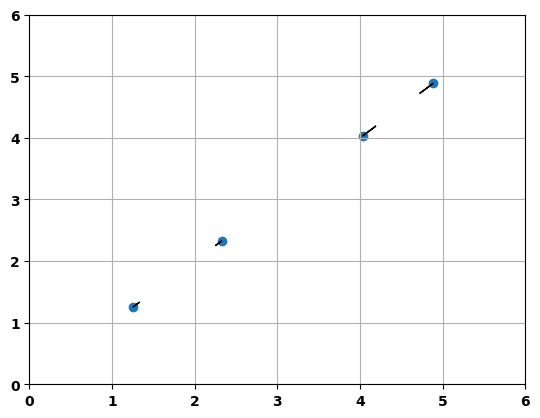

In [155]:
test_index=-1
plt.scatter(x_1[test_index],y_1[test_index])
#plt.scatter(x_1[test_index],y_1[test_index])
#plt.xlim(0,6)
#plt.ylim(0,6)
for i in range(0,len(x_1[test_index])):
    plt.arrow(x_1[test_index][i],y_1[test_index][i],0.1*ax_1[test_index][i],0.1*ay_1[test_index][i])
#for i in range(0,len(x_1[test_index])):
    #plt.arrow(x_1[test_index][i],y_1[test_index][i],0.1*ax_1[test_index][i],0.1*ay_1[test_index][i],color='r')
plt.xlim(0,6)
plt.ylim(0,6)
#plt.scatter(x_1[19],y_1[19])
#plt.xlim(0,6)
print(vx_1[test_index])
plt.grid(True)

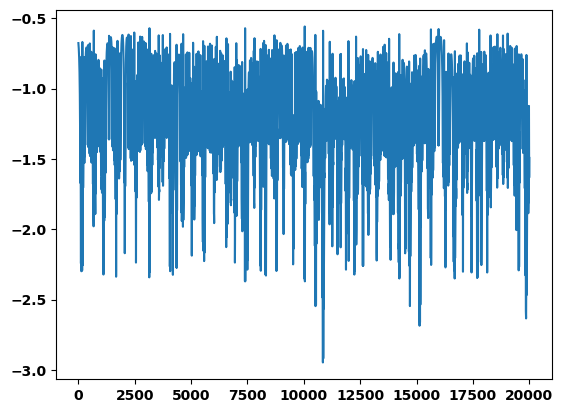

In [157]:
plt.plot([u_1[i]+k_1[i] for i in range(0,len(u_1))])